In [1]:
import numpy as np
from skfem import (
    MeshTri, Basis, FacetBasis, ElementTriP2, ElementTriP1, ElementVector,
    asm, bmat, condense, solve, BilinearForm, LinearForm, Mesh
)
from skfem.models.general import divergence
from skfem.models.poisson import vector_laplace
from skfem.helpers import grad, dot, laplacian
from skfem.helpers import laplacian, precompute_operators
import matplotlib.pyplot as plt

import scipy.sparse as sp
from scipy.sparse.linalg import eigsh, eigs, splu, LinearOperator

import scipy.linalg


In [183]:
def graficar_stokes(u_sol, p_sol, mesh, basis_p, basis_u):
    
    Nu = basis_u.N
    
    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))

    # Separar componentes de velocidad
    # Para ElementVector, los DOFs están organizados por componente
    n_nodes = Nu // 2
    u_x = u_sol[0::2]  # componente x
    u_y = u_sol[1::2]  # componente y

    # Magnitud de velocidad
    u_magnitude = np.sqrt(u_x**2 + u_y**2)

    # Crear bases escalares para visualizar cada componente
    basis_scalar = Basis(mesh, ElementTriP2(), intorder=4)

    # Componente u de la velocidad
    basis_scalar.plot(u_x, ax=axes[0, 0], shading='gouraud', colorbar=True)
    axes[0, 0].set_title(r'Velocidad $u_x$ (horizontal)')
    axes[0, 0].set_aspect('equal')

    # Componente v de la velocidad
    basis_scalar.plot(u_y, ax=axes[0, 1], shading='gouraud', colorbar=True)
    axes[0, 1].set_title(r'Velocidad $u_y$ (vertical)')
    axes[0, 1].set_aspect('equal')

    # Magnitud de velocidad
    basis_scalar.plot(u_magnitude, ax=axes[1, 0], shading='gouraud', colorbar=True)
    axes[1, 0].set_title(r'Magnitud de velocidad $|\mathbf{u}|$')
    axes[1, 0].set_aspect('equal')

    # Presión
    basis_p.plot(p_sol, ax=axes[1, 1], shading='gouraud', colorbar=True, colormap='viridis', cmap='viridis')
    axes[1, 1].set_title(r'Presión $p$')
    axes[1, 1].set_aspect('equal')
    plt.tight_layout()
    plt.show()

    # Campo vectorial de velocidad (quiver)
    # Para P2, necesitamos solo los valores en los vértices (primeros n_nodes)
    n_vertices = mesh.p.shape[1]
    
    # Extraer solo los valores en los vértices
    u_x_vertices = u_x[:n_vertices]
    u_y_vertices = u_y[:n_vertices]
    u_mag_vertices = np.sqrt(u_x_vertices**2 + u_y_vertices**2)
    
    # Obtener coordenadas de los nodos
    coords = mesh.p
    x_coords = coords[0, :]
    y_coords = coords[1, :]
    
    
    # Create a new figure for the quiver plot
    fig_quiver, ax_quiver = plt.subplots(1, 1, figsize=(10, 8))
    
    # Quiver plot
    quiver = ax_quiver.quiver(x_coords, y_coords, 
                      u_x_vertices, u_y_vertices, u_mag_vertices,
                      cmap='jet', scale=20, alpha=1, width=0.005)
    ax_quiver.set_title(r'Campo de velocidad $\mathbf{u}$')
    ax_quiver.set_aspect('equal')
    ax_quiver.set_xlabel('x')
    ax_quiver.set_ylabel('y')
    
    # Add colorbar
    cbar = plt.colorbar(quiver, ax=ax_quiver)
    cbar.set_label('Magnitud de velocidad')

    plt.tight_layout()
    plt.show()


In [184]:
malla = Mesh.load("data/Ugeom.obj", force_meshio_type='triangle')

In [185]:
nodes  = malla.p
facets = malla.facets
boundary_facets = malla.boundary_facets()
boundary_nodes = malla.boundary_nodes()

In [186]:
pared  = []
salida = []
for i,e in enumerate(boundary_facets):
    facets_e = facets[:, e]
    nodox = nodes[0, facets_e]
    nodoy = nodes[1, facets_e]
    m = np.array([np.mean(nodox), np.mean(nodoy)])

    if m[1] > -2.0:
        pared.append(e)
    if m[1] <= -2.0 and m[0] > 0.0:
        salida.append(e)

pared = np.array(pared)
salida = np.array(salida)

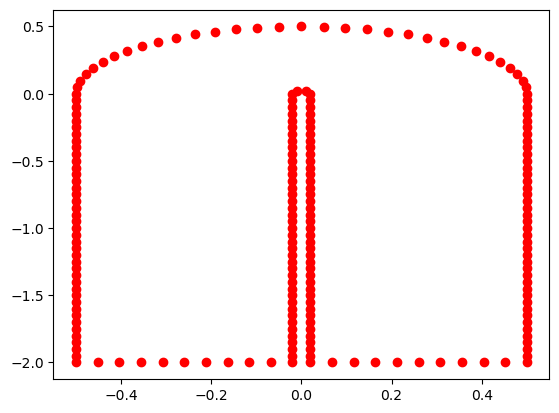

In [187]:
coordenadas = nodes[:, boundary_nodes]

plt.plot(coordenadas[0, :], coordenadas[1, :], 'ro')

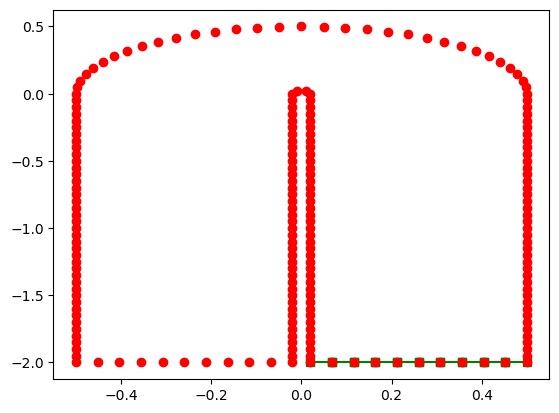

In [188]:
facets_e_list = []
for i, e in enumerate(boundary_facets):
    facets_e = facets[:, e]
    facets_e_list.append(facets_e)
    nodosx    = nodes[0, facets_e]
    nodosy    = nodes[1, facets_e]

    # plt.plot(nodosx, nodosy, 's-', color = 'b')

for i, e in enumerate(salida):
    facets_e = facets[:, e]
    nodosx    = nodes[0, facets_e]
    nodosy    = nodes[1, facets_e]

    plt.plot(nodosx, nodosy, 's-', color = 'g')

plt.plot(coordenadas[0, :], coordenadas[1, :], 'ro')

In [189]:
# Definir elementos y bases (P2 para velocidad, P1 para presión)
element = {
    'u': ElementVector(ElementTriP2()),
    'p': ElementTriP1(),
}
basis = {
    'u': Basis(malla, element['u'], intorder=4),
    'p': Basis(malla, element['p'], intorder=4),
}
basis_u, basis_p = basis['u'], basis['p']
Nu, Np = basis_u.N, basis_p.N
N      = Nu + Np

In [191]:
@LinearForm
def mean_vec(q, w):
    return q

m    = asm(mean_vec, basis_p)    # shape: (Np,)
Mcol = m.reshape((-1, 1))     # (Np,1)
Mrow = m.reshape((1,  -1))    # (1,Np)

In [192]:
@BilinearForm
def mass_matrix(u, v, w):
    return dot(u, v)
nu = 0.035
# Ensamblaje de matrices
A =  asm(vector_laplace, basis_u)               
B = -asm(divergence, basis_u, basis_p)   
M =  asm(mass_matrix, basis_u)   


# Construcción del ssitema
K = bmat([[nu*A,    B.T, None],
          [B,    None, Mcol],
          [None, Mrow, np.array([1])]], format='csr') 

zeros = sp.csr_matrix((basis_p.N, basis_p.N))  
L = bmat([[M,   None, None],
          [None, zeros, Mcol*0],
          [None, Mrow*0, None]], format='csr')


In [208]:
def u_out_y(x, y):
    return  (x-0.02)*(0.5-x) + y*0.0

dofs_pared   = basis_u.get_dofs(pared).all()
dofs_salida  = basis_u.get_dofs(salida).all()
xout   = basis_u.doflocs[0, dofs_salida[::2]] 
yout   = basis_u.doflocs[1, dofs_salida[1::2]]

x_boundaries = np.zeros(Nu+Np+1)
x_boundaries[dofs_salida[::2]]  = 0.0
x_boundaries[dofs_salida[1::2]] = 10*u_out_y(xout, yout)

D_all = np.concatenate([
    basis_u.get_dofs(pared).all(),
    basis_u.get_dofs(salida).all(), 
    # Nu + np.array([0])
]) 

In [209]:
A_sys, M_sys, xI, Ix  = condense(A=K, b=L, D=D_all, x=x_boundaries)
# M_sys, bIM, xIM, IM = condense(L, D=D_all, x=x_boundaries)

In [210]:
vals, vecs = eigs(A_sys, k=10, M=M_sys, sigma=0.0, which='LM', OPpart='r')

In [211]:
# Filtrar valores propios reales (parte imaginaria exactamente cero)
mask_real = np.isclose(vals.imag, 0)
vals = vals[mask_real].real
vecs = vecs[:, mask_real].real

# Ordenar autovalores
idx = np.argsort(vals)
eigenvalues = vals[idx]
eigenvectors = vecs[:, idx]

# Insertar la solución reducida en el vector global (con ceros en frontera)
u_sol = x_boundaries.copy()

sol_idx = 0
u_sol[Ix] = eigenvectors[:, sol_idx]  # Primer modo

# Separar componentes de velocidad y presión
u_velocity = u_sol[:Nu]
p_pressure = u_sol[Nu:]
# graficar_stokes(u_velocity, p_pressure, mesh, basis_p, basis_u)

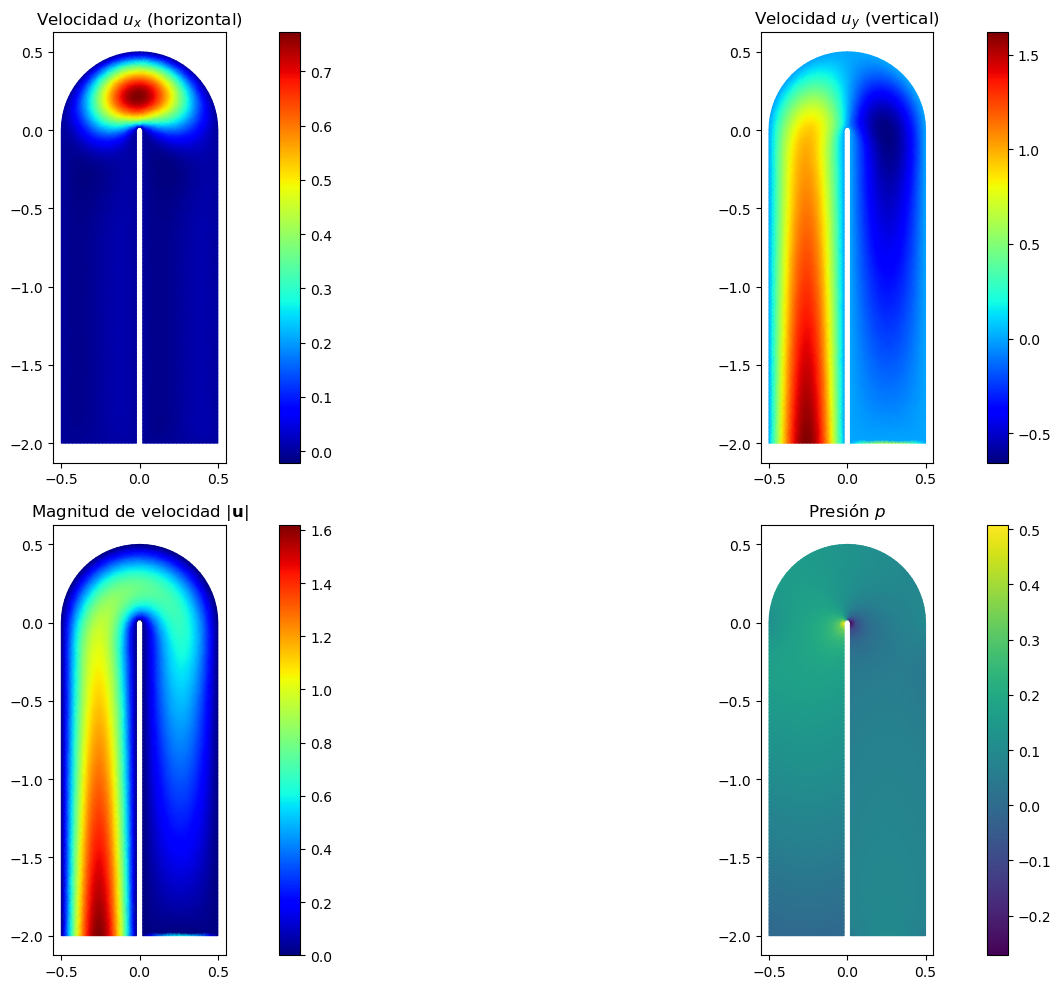

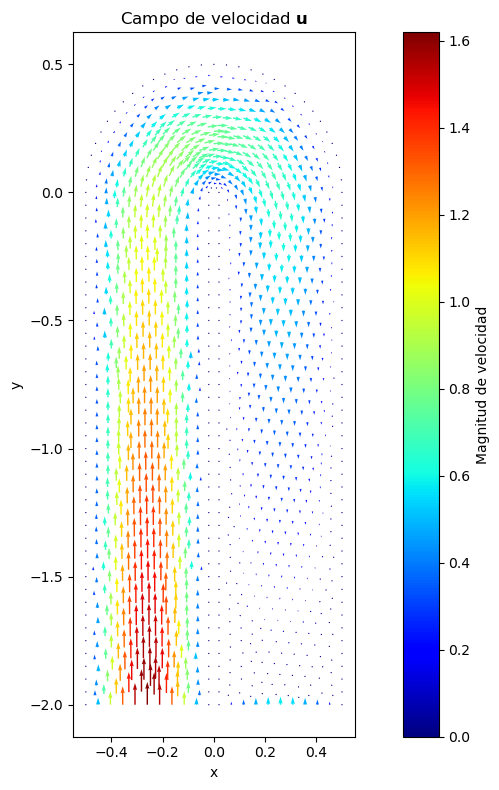

In [212]:
graficar_stokes(u_velocity, p_pressure, malla, basis_p, basis_u)

In [182]:
eigenvalues

array([1.60319732, 5.07829959, 5.40604571, 5.47615058, 5.69739984,
       5.70540458, 5.73645786, 5.76163432, 5.85635465, 5.90699793])